In [50]:
from CosinorPy import cosinor
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [51]:
# Dostop do datoteke
file_path = '../PrometneNesreče.csv'
data = pd.read_csv(file_path)

C:\Users\Hana\AppData\Local\Temp\ipykernel_18504\2677043888.py:3: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [68]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

data['Day_EN'] = data['NastanekDatumCas'].dt.day_name()

day_translation = {
    'Monday': 'Ponedeljek',
    'Tuesday': 'Torek',
    'Wednesday': 'Sreda',
    'Thursday': 'Četrtek',
    'Friday': 'Petek',
    'Saturday': 'Sobota',
    'Sunday': 'Nedelja'
}

data['Day_SLO'] = data['Day_EN'].map(day_translation)
# display(data)

### Število nesreč za vsak dan v tednu

In [53]:
# Za vsak vnos pridobi, kateri dan je bil
days_of_week = data['NastanekDatumCas'].dt.day_name()

# Preštej število nesreč za vsak dan (dnevi niso po vrsti)
accidents_per_day = days_of_week.value_counts()

# Ločena tabela, ki hrani število nesreč za vsak dan (dnevi v pravilnem vrstnem redu)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
accident_counts_array = [accidents_per_day.get(day, 0) for day in day_order]  # .get(day, 0) -> ta 0 je, če slučajno za kakšen dan ne bi bilo nesreč, bi potem vrednost za ta dan bila 0.

print("Število nesreč po dnevih od ponedeljka do nedelje:")
print(accident_counts_array)

#print("----------------------------")
#print(accidents_per_day)

Število nesreč po dnevih od ponedeljka do nedelje:
[4658, 4343, 4427, 4761, 5715, 5267, 4428]


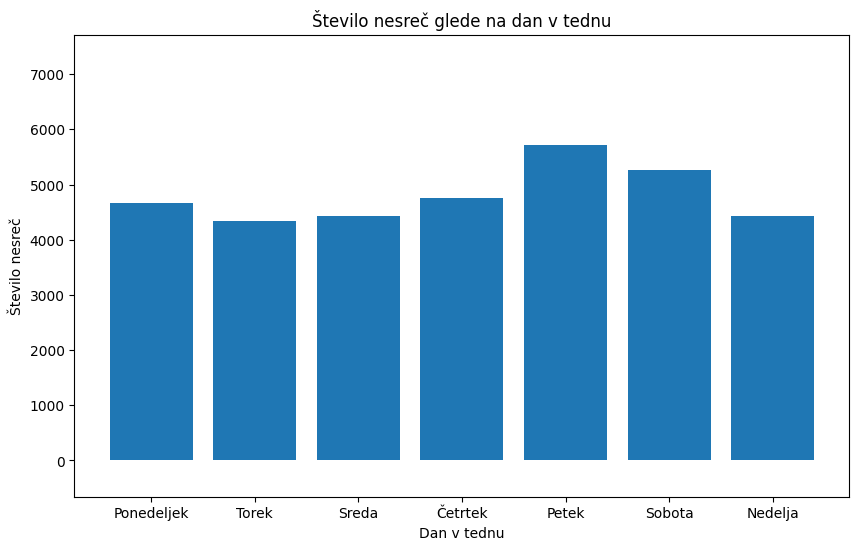

In [54]:
# Stolpčni diagram
day_order_slo = ['Ponedeljek', 'Torek', 'Sreda', 'Četrtek', 'Petek', 'Sobota', 'Nedelja']
plt.figure(figsize=(10, 6))
plt.bar(day_order_slo, accident_counts_array)

# Prilagodi skalo y-osi, da bodo razlike bolj vidne
plt.ylim(min(accident_counts_array) - 5000, max(accident_counts_array) + 2000)

plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč')
plt.title('Število nesreč glede na dan v tednu')

plt.show()

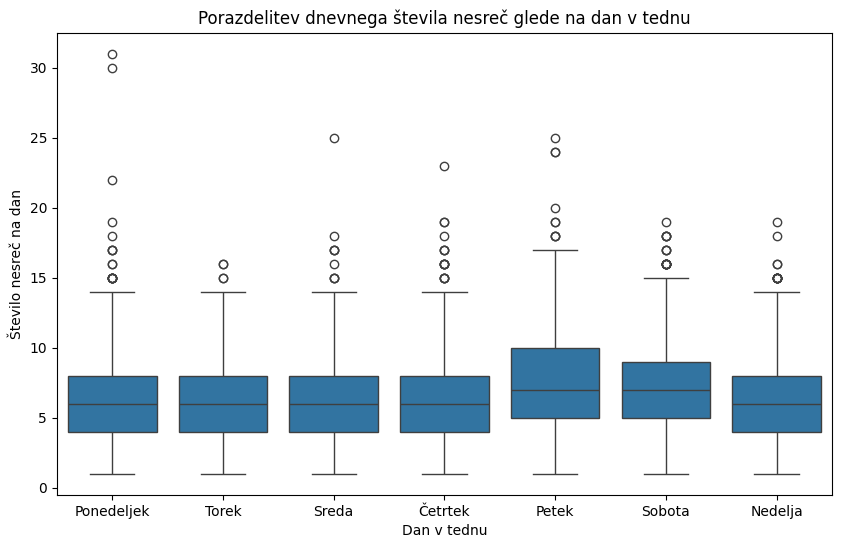

In [55]:
# Boxplot

# Grupiraj po datumih in preštej, koliko nesreč se je zgodilo vsak dan
grouped = data.groupby(data['NastanekDatumCas'].dt.date).size()

# Rezultat grupiranja pretvori v dataframe in stolpec s preštetimi prometnimi nesrečami poimenuj 'accident_count'
daily_accidents = grouped.reset_index(name='accident_count')

# Pridobi imena dni
daily_accidents['Day_EN'] = pd.to_datetime(daily_accidents['NastanekDatumCas']).dt.day_name()
daily_accidents['Day_SLO'] = daily_accidents['Day_EN'].map(day_translation)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day_SLO', y='accident_count', data=daily_accidents, order=day_order_slo)

plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč na dan')
plt.title('Porazdelitev dnevnega števila nesreč glede na dan v tednu')
plt.show()

## **Razlike med delovnikom in vikendom**

In [56]:
# Število nesreč med delovnikom in število nesreč med vikendom
accidents_workdays = sum(accident_counts_array[:5])
accidents_weekend = sum(accident_counts_array[-2:])

print(accidents_workdays)
print(accidents_weekend)

23904
9695


In [57]:
# Povprečje nesreč med delovnikom in povprečje nesreč med vikendom
avg_accidents_workdays = accidents_workdays / 5
avg_accidents_weekend = accidents_weekend / 2

print(avg_accidents_workdays, avg_accidents_weekend)

4780.8 4847.5


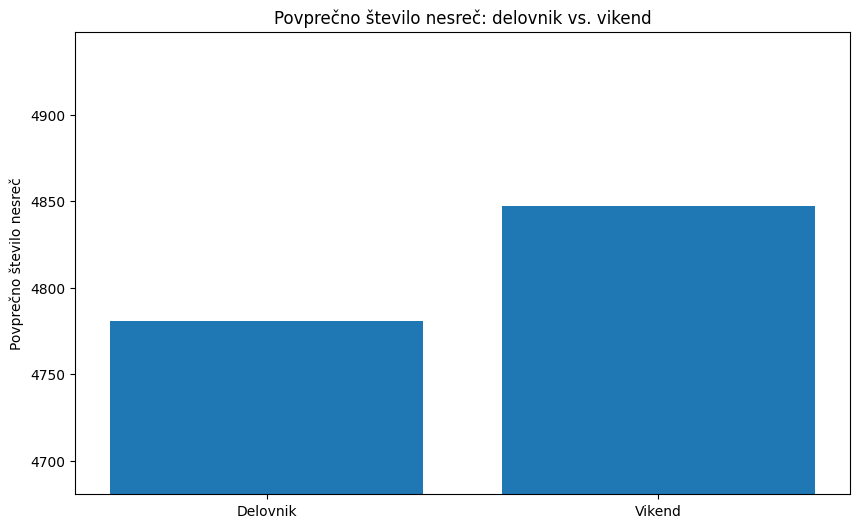

In [58]:
# Stolpčni diagram za povprečja
plt.figure(figsize=(10, 6))
plt.bar(["Delovnik", "Vikend"], [avg_accidents_workdays, avg_accidents_weekend])

# Prilagodi skalo y-osi, da bodo razlike bolj vidne
plt.ylim(min(avg_accidents_workdays, avg_accidents_weekend) - 100, max(avg_accidents_workdays, avg_accidents_weekend) + 100)

#plt.xlabel('Dan v tednu')
plt.ylabel('Povprečno število nesreč')
plt.title('Povprečno število nesreč: delovnik vs. vikend')

plt.show()

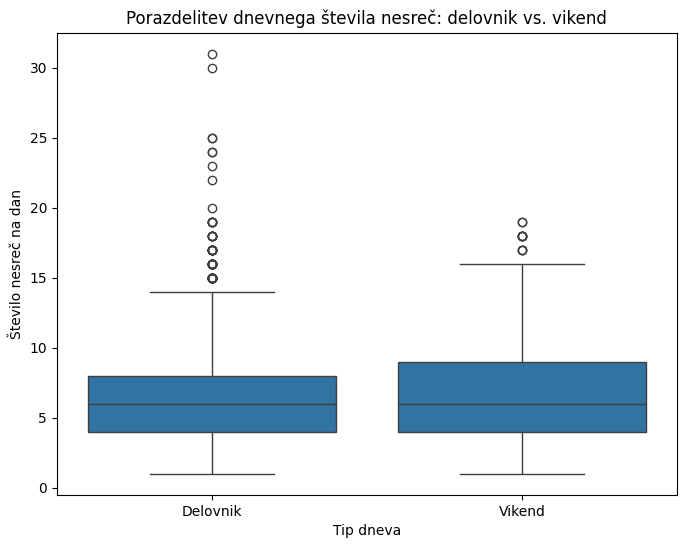

In [59]:
# Boxplot
workdays = ['Ponedeljek', 'Torek', 'Sreda', 'Četrtek', 'Petek']
weekend = ['Sobota', 'Nedelja']

daily_accidents['DayType'] = daily_accidents['Day_SLO'].apply(
    lambda d: 'Delovnik' if d in workdays else 'Vikend'
)

plt.figure(figsize=(8, 6))
sns.boxplot(x='DayType', y='accident_count', data=daily_accidents)

plt.xlabel('Tip dneva')
plt.ylabel('Število nesreč na dan')
plt.title('Porazdelitev dnevnega števila nesreč: delovnik vs. vikend')
plt.show()

# **Resnost posledic prometnih nesreč**

Tri kategorije nesreč:
- **Nesreče brez poškodovancev**: udeleženci niso bili poškodovani in nihče ni umrl
- **Nesreče s poškodbami**: nekateri udeleženci so bili poškodovani, vendar nihče ni umrl
- **Nesreče s smrtnim izidom**: vsaj eden od udeležencev je umrl (v nesreči so bili lahko tudi drugi, ki so bili poškodovani, vendar take nesreče ne štejem v kategorijo "Nesreče s poškodbami")

### Število nesreč s poškodbami vs. število nesreč brez poškodb

In [60]:
# Število nesreč brez poškodovancev in smrtnih žrtev
mild_accidents_entries = data[(data['LjudjeMrtvi'] == 0) & (data['LjudjePoskodovani'] == 0)] 
mild_accidents = mild_accidents_entries.shape[0]   # .shape vrne (number of rows, number of columns), zato [0]

# Število vseh nesreč
row_count = len(data)

# Število nesreč, kjer so bili ljudje poškodovani ali pa so umrli
severe_accidents = row_count - mild_accidents

# Nesreče s poškodbami (vendar brez smrtnih žrtev)
injury_accidents_entries = data[(data['LjudjeMrtvi'] == 0) & (data['LjudjePoskodovani'] != 0)]
injury_accidents = injury_accidents_entries.shape[0]

# Nesreče s smrtnimi žrtvami
death_accidents_entries = data[(data['LjudjeMrtvi'] != 0)]
death_accidents = death_accidents_entries.shape[0]

print("Nesreče brez poškodovancev: ", mild_accidents)
print("Nesreče s poškodbami in/ali smrtnimi žrtvami: ", severe_accidents)
print("Nesreče s poškodbami: ", injury_accidents)
print("Nesreče s smrtnim izidom: ", death_accidents)

Nesreče brez poškodovancev:  9443
Nesreče s poškodbami in/ali smrtnimi žrtvami:  24156
Nesreče s poškodbami:  22931
Nesreče s smrtnim izidom:  1225


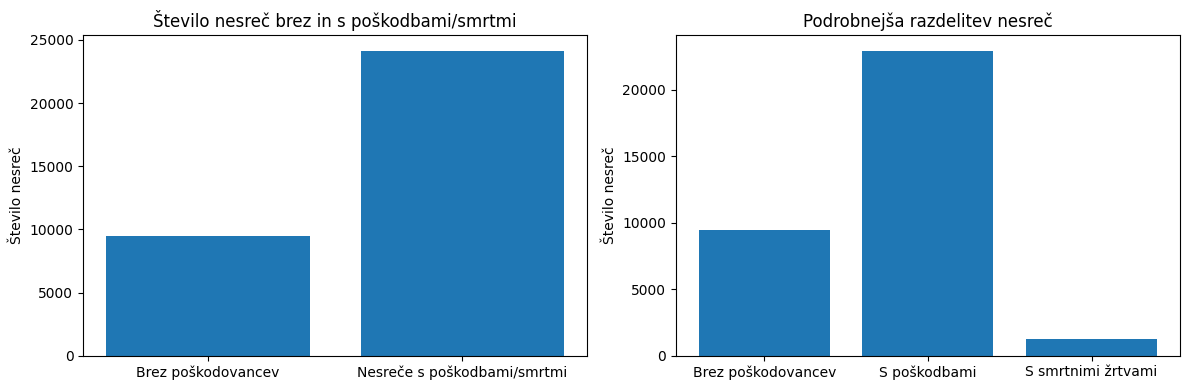

In [61]:
# Grafični prikaz
# Dva grafa - 1 vrstica, 2 stolpca
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(["Brez poškodovancev", "Nesreče s poškodbami/smrtmi"], [mild_accidents, severe_accidents])
axes[0].set_ylabel('Število nesreč')
axes[0].set_title('Število nesreč brez in s poškodbami/smrtmi')

axes[1].bar(["Brez poškodovancev", "S poškodbami", "S smrtnimi žrtvami"], [mild_accidents, injury_accidents, death_accidents])
axes[1].set_ylabel('Število nesreč')
axes[1].set_title('Podrobnejša razdelitev nesreč')

plt.tight_layout()
plt.show()

#### Priprava podatkov za boxplote

In [62]:
# Dodajanje stolpca za boxplot
# Nastavi pogoje
conditions = [
    (data['LjudjeMrtvi'] != 0),
    (data['LjudjePoskodovani'] != 0) & (data['LjudjeMrtvi'] == 0),
    (data['LjudjePoskodovani'] == 0) & (data['LjudjeMrtvi'] == 0)
]

# Določi oznake
severity_labels = ['death', 'injury', 'no_injury']

# Dodaj stolpec za severity
data['Severity'] = np.select(conditions, severity_labels, default='unknown')

data['Date'] = data['NastanekDatumCas'].dt.date
# display(data)

### Nesreče brez poškodovancev in brez smrtnih žrtev

In [63]:
# Za vsako nesrečo ugotovi, kateri dan je bila
mild_days = mild_accidents_entries['NastanekDatumCas'].dt.day_name()

# Koliko nesreč se je zgodilo v pon, koliko v tor...
mild_per_day = mild_days.value_counts()

mild_counts_array = [mild_per_day.get(day, 0) for day in day_order]

print(mild_counts_array)

[1321, 1215, 1238, 1380, 1628, 1471, 1190]


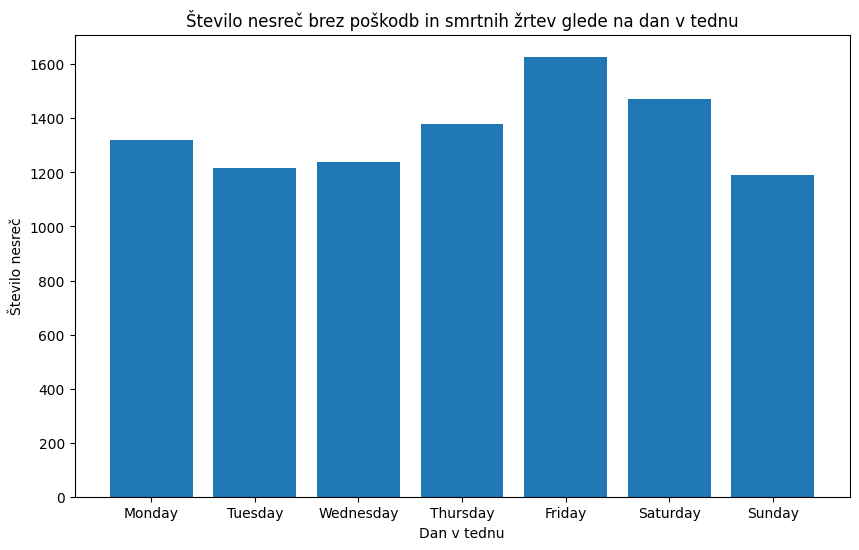

In [64]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(day_order, mild_counts_array)

plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč')
plt.title('Število nesreč brez poškodb in smrtnih žrtev glede na dan v tednu')

plt.show()

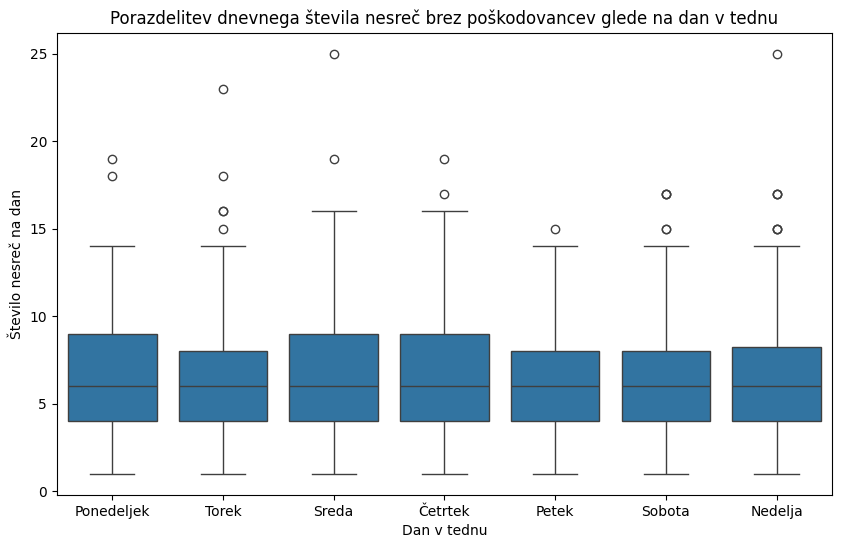

In [ ]:
# BOXPLOT
mask_no_injury = (data['Severity'] == 'no_injury')
df_no_injury = data[mask_no_injury]

# Grupiraj po datumih in preštej, koliko nesreč se je zgodilo vsak dan
grouped = data.groupby(data['Date']).size()

# Rezultat grupiranja pretvori v dataframe in stolpec s preštetimi prometnimi nesrečami poimenuj 'accident_count'
no_injury_accidents = grouped.reset_index(name='accident_count')
# display(no_injury_accidents)

# Pridobi imena dni
no_injury_accidents['Day_SLO'] = df_no_injury['Day_SLO']

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day_SLO', y='accident_count', data=no_injury_accidents, order=day_order_slo)

plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč na dan')
plt.title('Porazdelitev dnevnega števila nesreč brez poškodovancev glede na dan v tednu')
plt.show()

### Nesreče, v katerih so bili udeleženci poškodovani

In [ ]:
# Za vsako nesrečo ugotovi, kateri dan je bila
injury_days = injury_accidents_entries['NastanekDatumCas'].dt.day_name()

# Koliko nesreč se je zgodilo v pon, koliko v tor...
injury_per_day = injury_days.value_counts()

injury_counts_array = [injury_per_day.get(day, 0) for day in day_order]

print(injury_counts_array)

[3161, 2986, 3037, 3194, 3908, 3593, 3052]


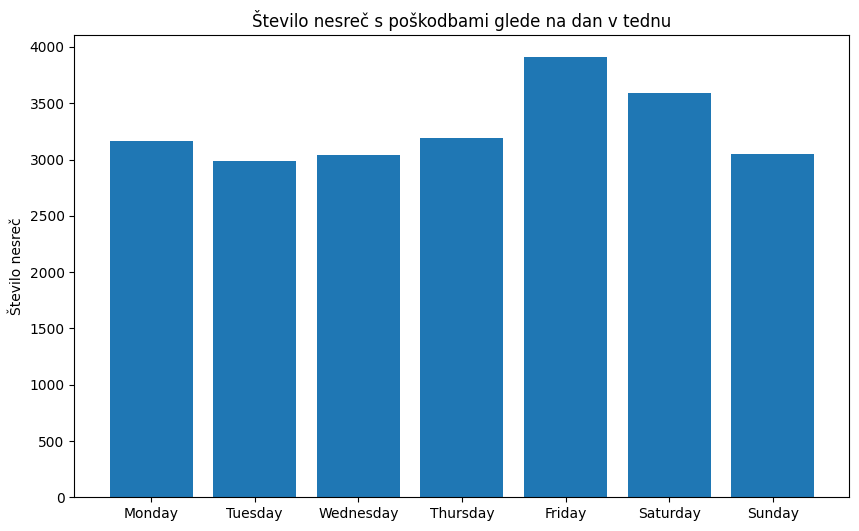

In [ ]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(day_order, injury_counts_array)

plt.ylabel('Število nesreč')
plt.title('Število nesreč s poškodbami glede na dan v tednu')

plt.show()

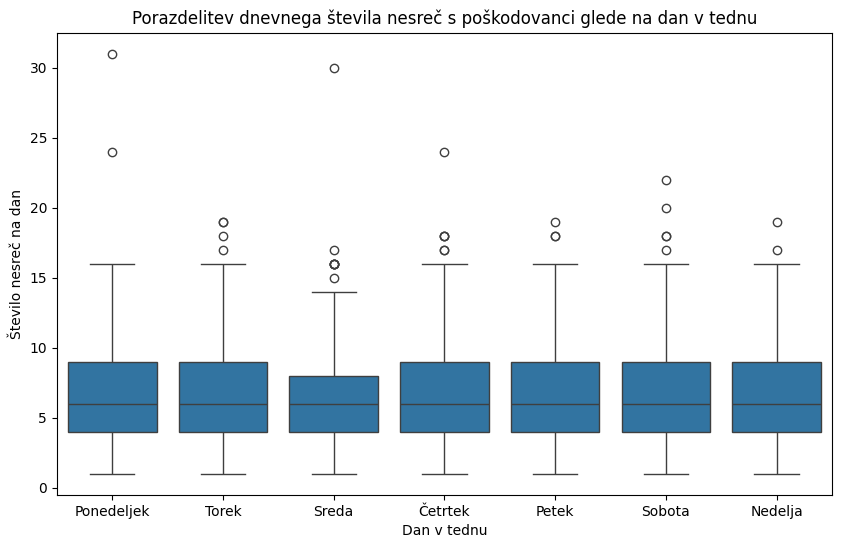

In [74]:
# BOXPLOT
mask_injury = (data['Severity'] == 'injury')
df_injury = data[mask_injury]

# Grupiraj po datumih in preštej, koliko nesreč se je zgodilo vsak dan
grouped = data.groupby(data['Date']).size()

# Rezultat grupiranja pretvori v dataframe in stolpec s preštetimi prometnimi nesrečami poimenuj 'accident_count'
injury_accidents = grouped.reset_index(name='accident_count')
# display(injury_accidents)

# Pridobi imena dni
injury_accidents['Day_SLO'] = df_injury['Day_SLO']

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day_SLO', y='accident_count', data=injury_accidents, order=day_order_slo)

plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč na dan')
plt.title('Porazdelitev dnevnega števila nesreč s poškodovanci glede na dan v tednu')
plt.show()

### Nesreče s smrtnimi žrtvami

In [ ]:
# Za vsako nesrečo ugotovi, kateri dan je bila
death_days = death_accidents_entries['NastanekDatumCas'].dt.day_name()

# Koliko nesreč se je zgodilo v pon, koliko v tor...
death_per_day = death_days.value_counts()

death_counts_array = [death_per_day.get(day, 0) for day in day_order]

print(death_counts_array)

[176, 142, 152, 187, 179, 203, 186]


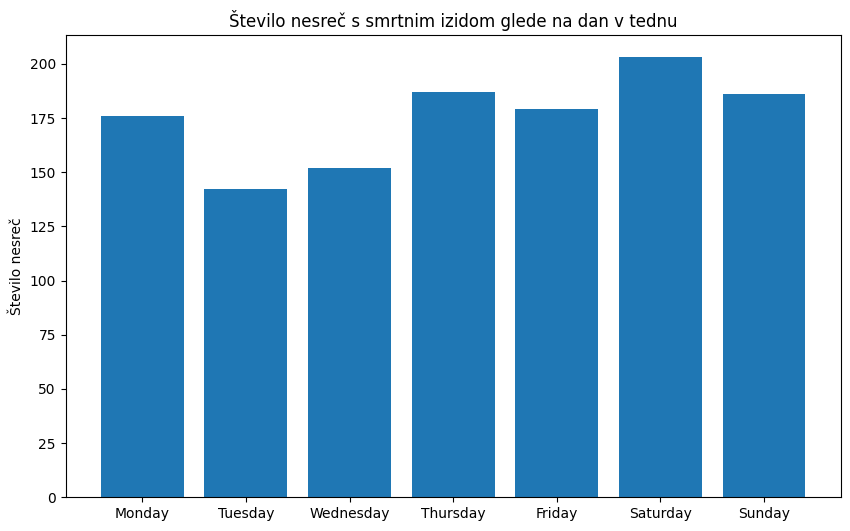

In [ ]:
# Stolpčni diagram
plt.figure(figsize=(10, 6))
plt.bar(day_order, death_counts_array)

plt.ylabel('Število nesreč')
plt.title('Število nesreč s smrtnim izidom glede na dan v tednu')

plt.show()

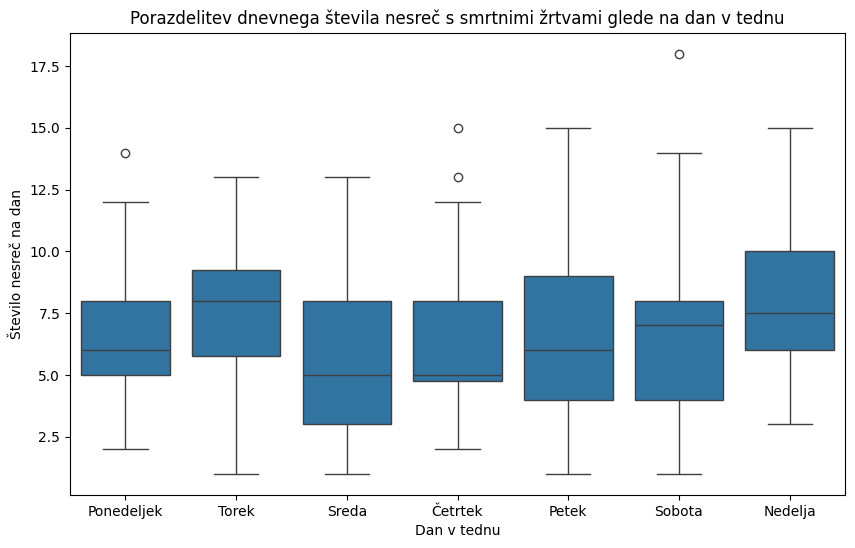

In [75]:
# BOXPLOT
mask_death = (data['Severity'] == 'death')
df_death = data[mask_death]

# Grupiraj po datumih in preštej, koliko nesreč se je zgodilo vsak dan
grouped = data.groupby(data['Date']).size()

# Rezultat grupiranja pretvori v dataframe in stolpec s preštetimi prometnimi nesrečami poimenuj 'accident_count'
death_accidents = grouped.reset_index(name='accident_count')
# display(death_accidents)

# Pridobi imena dni
death_accidents['Day_SLO'] = df_death['Day_SLO']

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day_SLO', y='accident_count', data=death_accidents, order=day_order_slo)

plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč na dan')
plt.title('Porazdelitev dnevnega števila nesreč s smrtnimi žrtvami glede na dan v tednu')
plt.show()

### Prikaz števila vseh treh kategorij nesreč

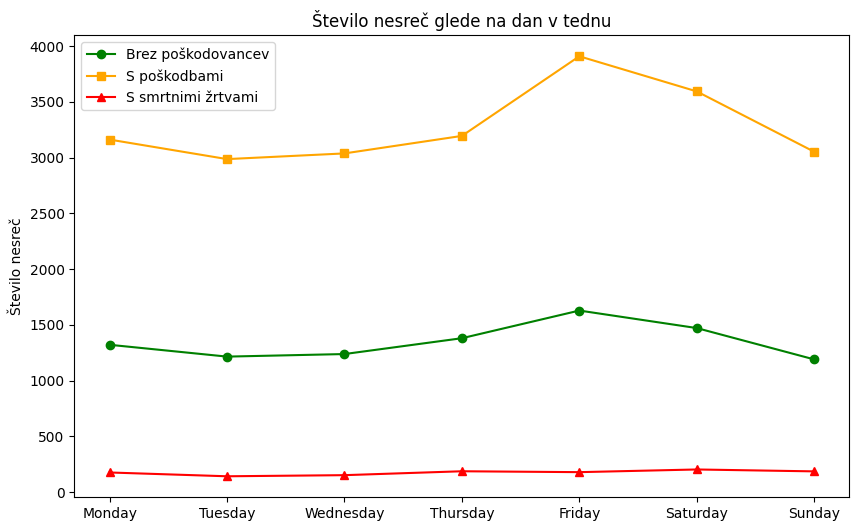

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(day_order, mild_counts_array, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(day_order, injury_counts_array, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(day_order, death_counts_array, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.ylabel('Število nesreč')
plt.title('Število nesreč glede na dan v tednu')
plt.legend()

plt.show()

### Prikaz normaliziranih vrednosti za lažjo primerjavo

X_norm = (X - X_min) / (X_max - X_min)

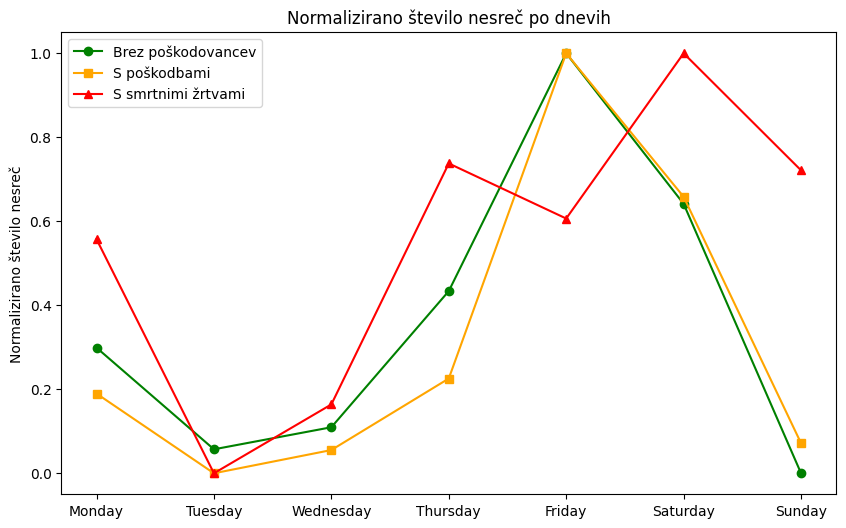

In [ ]:
# Normaliziranje
mild_norm = (mild_counts_array - np.min(mild_counts_array)) / (np.max(mild_counts_array) - np.min(mild_counts_array))
injury_norm = (injury_counts_array - np.min(injury_counts_array)) / (np.max(injury_counts_array) - np.min(injury_counts_array))
death_norm = (death_counts_array - np.min(death_counts_array)) / (np.max(death_counts_array) - np.min(death_counts_array))

plt.figure(figsize=(10, 6))

plt.plot(day_order, mild_norm, marker='o', linestyle='-', label='Brez poškodovancev', color='green')
plt.plot(day_order, injury_norm, marker='s', linestyle='-', label='S poškodbami', color='orange')
plt.plot(day_order, death_norm, marker='^', linestyle='-', label='S smrtnimi žrtvami', color='red')

plt.ylabel('Normalizirano število nesreč')
plt.title('Normalizirano število nesreč po dnevih')
plt.legend()

plt.show()


### Boxplot

In [ ]:
# Dodajanje stolpca za boxplot
# Nastavi pogoje
conditions = [
    (data['LjudjeMrtvi'] != 0),
    (data['LjudjePoskodovani'] != 0) & (data['LjudjeMrtvi'] == 0),
    (data['LjudjePoskodovani'] == 0) & (data['LjudjeMrtvi'] == 0)
]

# Določi oznake
severity_labels = ['death', 'injury', 'no_injury']

# Dodaj stolpec za severity
data['Severity'] = np.select(conditions, severity_labels, default='unknown')
# display(data)

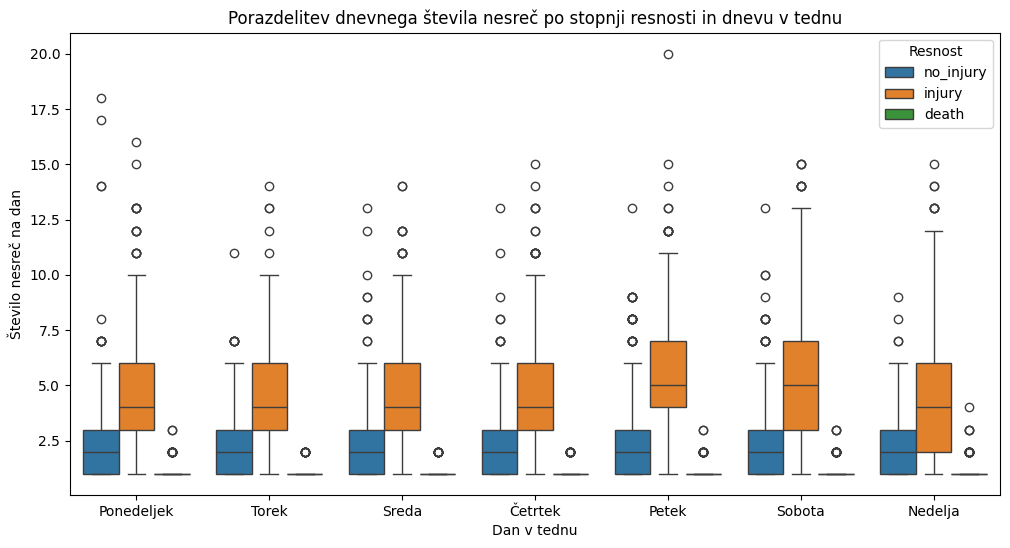

In [ ]:
# BOXPLOT


# Grupiraj in preštej, koliko nesreč se je zgodilo vsak dan
grouped = data.groupby(['Date', 'Day_SLO', 'Severity']).size()

# Rezultat grupiranja pretvori v dataframe in stolpec s preštetimi prometnimi nesrečami poimenuj 'accident_count'
daily_accidents_severity = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Day_SLO',
    y='accident_count',
    hue='Severity',
    data=daily_accidents_severity,
    order=day_order_slo
)

plt.xlabel('Dan v tednu')
plt.ylabel('Število nesreč na dan')
plt.title('Porazdelitev dnevnega števila nesreč po stopnji resnosti in dnevu v tednu')
plt.legend(title='Resnost')
plt.show()

### Heatmap

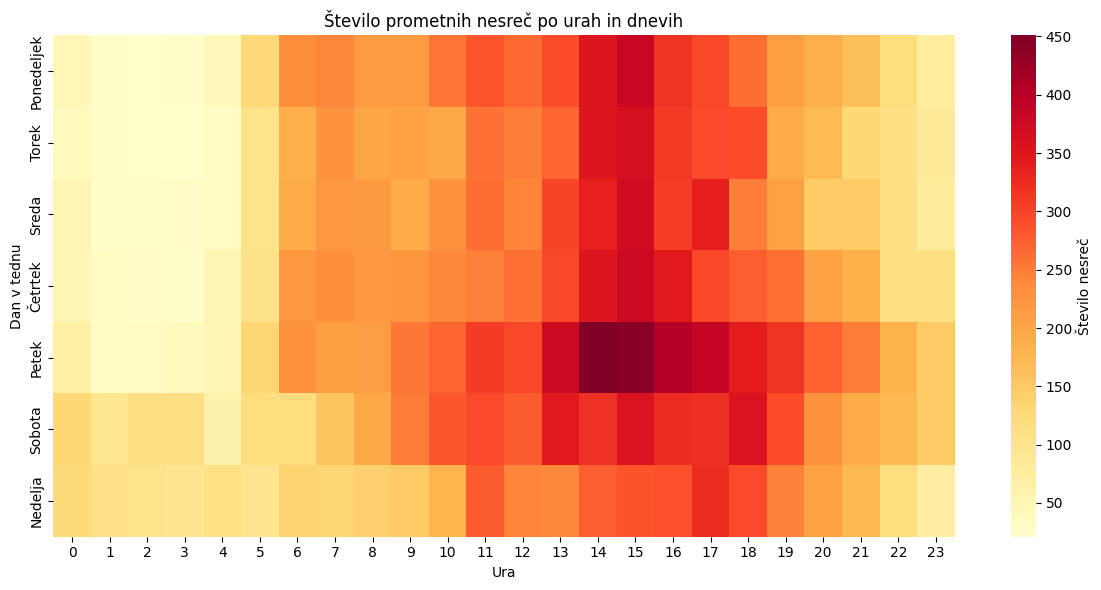

In [ ]:
data['Hour'] = data['NastanekDatumCas'].dt.hour

grouped = data.groupby(['Day_SLO', 'Hour']).size()
grouped = grouped.reset_index(name='accident_count')

# Dneve v tednu razporedi po vrstnem redu
cat_type = CategoricalDtype(categories=day_order_slo, ordered=True)
grouped['Day_SLO'] = grouped['Day_SLO'].astype(cat_type)
grouped = grouped.sort_values(['Day_SLO', 'Hour'])

df_heatmap = grouped.pivot(index='Day_SLO', columns='Hour', values='accident_count').fillna(0)
# display(df_heatmap)

# Create heatmap using seaborn instead
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Ura')
plt.ylabel('Dan v tednu')
plt.title('Število prometnih nesreč po urah in dnevih')
plt.tight_layout()
plt.show()
